In [1]:
import json
import os
from os import listdir
from os.path import isfile, join, isdir
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

import tabulate
import numpy as np
import math

from itertools import cycle, islice


from collect_data import collect_statistics

In [2]:
fig_width = 8
fig_height = 5

params = {
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    #'text.usetex': True,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'grid.linestyle': '--',
    'lines.linewidth': 2
}

matplotlib.rcParams.update(params)

In [3]:
out_dir = join('..', 'plots', 'parallelization_exp')
event_dir = join('..', 'data', 'spark_logs-parallelization_exp')
memory_dir = join(event_dir, 'spark-memory')

In [4]:
appname = 'LUBM'
data_size_dir = 'LUBM'
collections = ['schemex', 'attribute', 'type']
suffix = ''
hide_legend = False

appname = 'BSBM'
data_size_dir = 'BSBM'
collections = ['attribute']#, 'type', 'schemex'] #, 
parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
#parallizations = ['parallel_16', 'parallel_8', 'parallel_4', 'parallel_2', 'parallel_1']

suffix = '-test-1'
hide_legend = False
# BSBM_attribute-parallel_1-test-1-performance.csv'

# BSBM-attribute-parallel_1-test-1-performance.csv


#appname = 'dyldo_y2019_full'
#data_size_dir = 'DyLDO-ext'
#collections =['schemex', 'attribute', 'type']
#suffix = ''
#hide_legend = True
"""
appname = 'DyLDO-core'
data_size_dir = 'DyLDO-core'
collections =['attribute']
parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
suffix = '-test-2'
hide_legend = False
"""


ticks = 5.0
interpolate = True

In [5]:
iterations = 0

performance_frame = pd.DataFrame() 
run_details_frame = pd.DataFrame()
for collection in collections:
#    new_zero_incr = 0
#    new_zero_batch = 0
    for parallelization in parallizations:
        # def collectStatistics(analyze_app, event_dir='/tmp/spark-events', memory_dir='/tmp/spark-memory'):   

        df = collect_statistics(appname+'-'+collection+'-'+parallelization+suffix, 
                               event_dir=event_dir, 
                               memory_dir=memory_dir) 
        
        performance_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
        performance_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']
        
        run_details_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
        run_details_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']
        run_details_frame[collection+'-'+parallelization+'-Inc F&M'] = df['Incremental F&M Duration']
        run_details_frame[collection+'-'+parallelization+'-Batch F&M'] = df['Batch F&M Duration']        
    
    

#performance_frame.columns = ['SchemEX:Incr', 'SchemEX:Batch', 
#             'AttrColl:Incr', 'AttrColl:Batch',
#             'TypeColl:Incr', 'TypeColl:Batch']
 
convert = lambda x: x / 1000 / 60
performance_frame = performance_frame.applymap(convert)  
run_details_frame = run_details_frame.applymap(convert)

display(performance_frame.head())
display(run_details_frame.head())

if (appname == 'dyldo_y2019_core' or appname == 'DyLDO-core') and len(performance_frame) > 23:
    performance_frame = performance_frame.drop(performance_frame.index[[21,22]])
    run_details_frame = run_details_frame.drop(run_details_frame.index[[21,22]])
    
if appname == 'dyldo_y2019_full':
    performance_frame = performance_frame.head()
    run_details_frame = run_details_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
 

,attribute-parallel_1-Inc,attribute-parallel_1-Batch,attribute-parallel_2-Inc,attribute-parallel_2-Batch,attribute-parallel_4-Inc,attribute-parallel_4-Batch,attribute-parallel_8-Inc,attribute-parallel_8-Batch,attribute-parallel_16-Inc,attribute-parallel_16-Batch
Iteration,,,,,,,,,,
0,0.300883,0.422300,0.223483,0.244533,0.148633,0.160667,0.155467,0.141883,0.176333,0.162500
1,2.487367,3.174783,1.470883,2.528350,0.993050,1.504200,0.965383,1.133167,1.122800,1.199117
2,4.178717,5.723617,2.610333,5.353800,1.898133,2.661550,1.881367,2.275583,2.055633,2.376483
3,6.352917,8.503567,3.913367,6.188933,2.731000,4.324967,2.903950,3.404133,3.210083,3.378733
4,8.057300,11.315683,4.875683,12.454500,3.621983,5.497783,3.648033,4.306867,4.341450,4.289367


,attribute-parallel_1-Inc,attribute-parallel_1-Batch,attribute-parallel_1-Inc F&M,attribute-parallel_1-Batch F&M,attribute-parallel_2-Inc,attribute-parallel_2-Batch,attribute-parallel_2-Inc F&M,attribute-parallel_2-Batch F&M,attribute-parallel_4-Inc,attribute-parallel_4-Batch,attribute-parallel_4-Inc F&M,attribute-parallel_4-Batch F&M,attribute-parallel_8-Inc,attribute-parallel_8-Batch,attribute-parallel_8-Inc F&M,attribute-parallel_8-Batch F&M,attribute-parallel_16-Inc,attribute-parallel_16-Batch,attribute-parallel_16-Inc F&M,attribute-parallel_16-Batch F&M
Iteration,,,,,,,,,,,,,,,,,,,,
0,0.300883,0.422300,0.044117,0.178683,0.223483,0.244533,0.035550,0.082483,0.148633,0.160667,0.039217,0.066000,0.155467,0.141883,0.046700,0.053883,0.176333,0.162500,0.061833,0.066250
1,2.487367,3.174783,0.163400,1.123067,1.470883,2.528350,0.210000,1.292550,0.993050,1.504200,0.253900,0.734217,0.965383,1.133167,0.266383,0.421783,1.122800,1.199117,0.428467,0.504467
2,4.178717,5.723617,0.297683,2.127067,2.610333,5.353800,0.326583,3.219317,1.898133,2.661550,0.474500,1.278783,1.881367,2.275583,0.537117,0.991683,2.055633,2.376483,0.727950,1.078600
3,6.352917,8.503567,0.407900,3.175117,3.913367,6.188933,0.542150,2.574317,2.731000,4.324967,0.709150,2.262067,2.903950,3.404133,0.944867,1.472667,3.210083,3.378733,1.256900,1.416900
4,8.057300,11.315683,0.597767,4.109617,4.875683,12.454500,0.630233,7.496367,3.621983,5.497783,0.950817,2.735067,3.648033,4.306867,1.062233,1.740350,4.341450,4.289367,1.795367,1.745217


0.20403333333333334
30


[(20, 'indianred'), (30, 'forestgreen'), (40, 'darkslateblue')]

(20, 30, 40)

('indianred', 'forestgreen', 'darkslateblue')

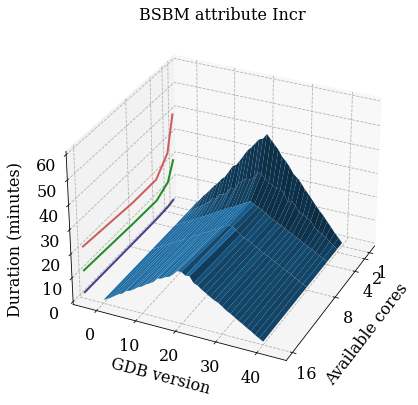

0.32444999999999996
30


[(20, 'indianred'), (30, 'forestgreen'), (40, 'darkslateblue')]

(20, 30, 40)

('indianred', 'forestgreen', 'darkslateblue')

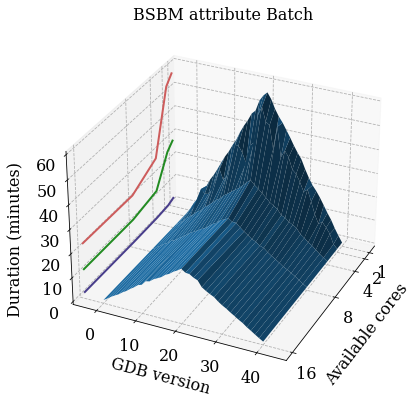

In [25]:
#box = dict(facecolor='white', pad=5, alpha=0.2)


def my_3d_plot(x, y, values, plot_name, z_lim=None, save_dir=None):
    y_offset = 5
    
    # prepare data   
    X, Y = np.meshgrid(x, y)
    Z = np.transpose(np.array(values))
    
    
    fig = plt.figure()
    ax = Axes3D(fig)
      
    # plot the data
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    
    # add contour lines for readability
    print(np.min(values[0]))
    min_index = np.argmin(values[0])
    max_index = np.argmax(values[0])
    
    median_index = list(values[0]).index(np.percentile(values[0], 50, interpolation='nearest'))

    print(median_index)
    lvls = [min_index, median_index, max_index]
    colors = ['darkslateblue', 'forestgreen', 'indianred']
    temp = list(zip(lvls, colors))
    temp.sort(key=lambda x: x[0])
    display(temp)
    lvls, colors = zip(*temp)
    display(lvls)
    display(colors)
    
    # TODO: 40 is not displayed properly
    if lvls[2] == 40:
        lvls = list(lvls)
        lvls[2] = 39
    #lvls = [20,30,39]
    cset = ax.contour(X, Y, Z, zdir='y', levels=lvls, offset=-y_offset, colors=colors)

    ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    #fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(plot_name)
    plt.xticks(x)
    ax.view_init(30, 25)
    
    if z_lim:
        ax.set_zlim([0, z_lim])

    #ax.set_ylim([-y_offset, len(y)+y_offset])
    ax.set_ylim([-y_offset, len(y)+y_offset])
    
    ax.set_xlabel("Available cores", labelpad=10)
    ax.set_ylabel("GDB version", labelpad=10)

    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel("Duration (minutes)", rotation=90, labelpad=10)
    
    #fig.colorbar.remove()
    
    if save_dir:
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.pdf',  bbox_inches='tight')
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.png',  bbox_inches='tight', dpi=300)
        
    plt.show()


for collection in collections:
    values_incr = []
    values_batch = []
    for parallelization in parallizations:
        values_incr.append(np.array(performance_frame[collection+'-'+parallelization+'-Inc']))
        values_batch.append(np.array(performance_frame[collection+'-'+parallelization+'-Batch']))
        
    ## TODO parameterize
    x = [1,2,4,8,16]
    y = np.arange(0, len(performance_frame), 1) # 41

    z_lim = performance_frame.max().max()
    z_lim += z_lim/10
    z_lim = 5 * round(z_lim/5)

    my_3d_plot(x, y, values_incr, '%s %s Incr' % (appname, collection), z_lim=60, save_dir=out_dir)
    
    my_3d_plot(x, y, values_batch, '%s %s Batch' % (appname, collection), z_lim=60, save_dir=out_dir)


#     for angle in range(0, 360):
#         ax.view_init(30, angle)
#         plt.draw()
#         plt.pause(.001)


In [7]:
def deduplicate(input_list):
    seen = set()
    new_list = []
    for item in input_list:
        if item not in seen:
            new_list.append(item)
            seen.add(item)
    return new_list


In [8]:
# some speed-up analysis
#display(performance_frame)
speed_up_frame = pd.DataFrame(columns=deduplicate([x.replace('-Inc', '').replace('-Batch', '') for x in performance_frame.columns]))

for collection in collections:
    for parallelization in parallizations:
        speed_up_frame[collection+'-'+parallelization] = performance_frame[collection+'-'+parallelization+'-Batch'] /performance_frame[collection+'-'+parallelization+'-Inc']
        print('batch runs faster than incremental for %s: %s' % (collection+'-'+parallelization, (speed_up_frame[collection+'-'+parallelization] < 1.0).sum()))

display(speed_up_frame.mean())
display(speed_up_frame.std())    
display(speed_up_frame.mean().min())
display(speed_up_frame.mean().max())  

batch runs faster than incremental for attribute-parallel_1: 0
batch runs faster than incremental for attribute-parallel_2: 0
batch runs faster than incremental for attribute-parallel_4: 0
batch runs faster than incremental for attribute-parallel_8: 1
batch runs faster than incremental for attribute-parallel_16: 3


attribute-parallel_1     1.440052
attribute-parallel_2     1.826764
attribute-parallel_4     1.464468
attribute-parallel_8     1.162826
attribute-parallel_16    1.068840
dtype: float64

attribute-parallel_1     0.050394
attribute-parallel_2     0.304808
attribute-parallel_4     0.081707
attribute-parallel_8     0.049375
attribute-parallel_16    0.042953
dtype: float64

1.0688399013235144

1.8267636241144851

In [9]:
t1 = (performance_frame['attribute-parallel_1-Batch'] /performance_frame['attribute-parallel_1-Inc']).mean()
t2 = (performance_frame['attribute-parallel_1-Batch'].sum() /performance_frame['attribute-parallel_1-Inc'].sum())

In [10]:
display(t1)
display(t2)

1.440051708050351

1.4408311354606362

In [11]:
for collection in collections:
    for parallelization in parallizations:
        macro_avg = (performance_frame['%s-%s-Batch' % (collection, parallelization)] / performance_frame['%s-%s-Inc'  % (collection, parallelization)]).mean()
        micro_avg = (performance_frame['%s-%s-Batch' % (collection, parallelization)].sum() / performance_frame['%s-%s-Inc'  % (collection, parallelization)].sum())
        print('%s - Micro Avg: %s' % (parallelization, micro_avg.round(2)))
        print('%s - Macro Avg: %s' % (parallelization, macro_avg.round(2)))

parallel_1 - Micro Avg: 1.44
parallel_1 - Macro Avg: 1.44
parallel_2 - Micro Avg: 1.86
parallel_2 - Macro Avg: 1.83
parallel_4 - Micro Avg: 1.48
parallel_4 - Macro Avg: 1.46
parallel_8 - Micro Avg: 1.17
parallel_8 - Macro Avg: 1.16
parallel_16 - Micro Avg: 1.07
parallel_16 - Macro Avg: 1.07


In [12]:
# print((all_frame['batch'] / all_frame['incr']).mean())
# print(all_frame['batch'].sum() / all_frame['incr'].sum())

In [13]:
for col in performance_frame.columns:
    if 'parallel_1-Inc' in col:
        #baseline
        baseline = performance_frame[col]
    elif '-Batch' in col:
        print('%s has faster runs than baseline? %s' % (col, (performance_frame[col] - baseline < 0).sum()))
        

attribute-parallel_1-Batch has faster runs than baseline? 0
attribute-parallel_2-Batch has faster runs than baseline? 9
attribute-parallel_4-Batch has faster runs than baseline? 41
attribute-parallel_8-Batch has faster runs than baseline? 41
attribute-parallel_16-Batch has faster runs than baseline? 41


In [14]:
parallelization_frame = pd.DataFrame()
for collection in collections:
    for i in range(1, len(parallizations)):
        prev = parallizations[i-1]
        current = parallizations[i]
        parallelization_frame[collection+'-'+current+'-Batch'] = performance_frame[collection+'-'+prev+'-Batch'] / performance_frame[collection+'-'+current+'-Batch'] 
        parallelization_frame[collection+'-'+current+'-Inc'] = performance_frame[collection+'-'+prev+'-Inc'] / performance_frame[collection+'-'+current+'-Inc'] 
            
display(parallelization_frame.mean())
display(parallelization_frame.std())

attribute-parallel_2-Batch     1.251550
attribute-parallel_2-Inc       1.549479
attribute-parallel_4-Batch     1.748837
attribute-parallel_4-Inc       1.404745
attribute-parallel_8-Batch     1.240013
attribute-parallel_8-Inc       0.984821
attribute-parallel_16-Batch    0.984149
attribute-parallel_16-Inc      0.904780
dtype: float64

attribute-parallel_2-Batch     0.203753
attribute-parallel_2-Inc       0.091678
attribute-parallel_4-Batch     0.264972
attribute-parallel_4-Inc       0.060656
attribute-parallel_8-Batch     0.049788
attribute-parallel_8-Inc       0.023703
attribute-parallel_16-Batch    0.030420
attribute-parallel_16-Inc      0.029302
dtype: float64

In [15]:
# overall gain:
skip_rows = 1

t_frame = performance_frame[collection+'-parallel_1-Batch'] / performance_frame[collection+'-parallel_16-Batch']
print('Speed-up batch 1 to 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))


t_frame = performance_frame.iloc[skip_rows:][collection+'-parallel_1-Inc'] / performance_frame.iloc[skip_rows:][collection+'-parallel_16-Inc']
print('Speed-up incr. 1 to 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))


Speed-up batch 1 to 16 between 2.4084 and 2.7197 (mean: 2.6055 +- 0.0718)
Speed-up incr. 1 to 16 between 1.8324 and 2.2153 (mean: 1.9399 +- 0.0679)


In [16]:
# one core incr. vs 16 core batch

t_frame = performance_frame.iloc[skip_rows:][collection+'-parallel_16-Batch'] / performance_frame.iloc[skip_rows:][collection+'-parallel_1-Inc']
print('Speed-up incr. 1 to batch 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))



Speed-up incr. 1 to batch 16 between 0.4821 and 0.6125 (mean: 0.5533 +- 0.0214)


In [17]:
display(performance_frame.iloc[skip_rows:].mean())
display(performance_frame.iloc[skip_rows:].std())
display(performance_frame.iloc[skip_rows:].min())
display(performance_frame.iloc[skip_rows:].max())

attribute-parallel_1-Inc       19.931265
attribute-parallel_1-Batch     28.717868
attribute-parallel_2-Inc       12.810110
attribute-parallel_2-Batch     23.798361
attribute-parallel_4-Inc        9.134642
attribute-parallel_4-Batch     13.536546
attribute-parallel_8-Inc        9.279867
attribute-parallel_8-Batch     10.828643
attribute-parallel_16-Inc      10.292899
attribute-parallel_16-Batch    11.002045
dtype: float64

attribute-parallel_1-Inc       11.664395
attribute-parallel_1-Batch     16.805436
attribute-parallel_2-Inc        7.471113
attribute-parallel_2-Batch     14.549183
attribute-parallel_4-Inc        5.332365
attribute-parallel_4-Batch      7.903124
attribute-parallel_8-Inc        5.411941
attribute-parallel_8-Batch      6.276385
attribute-parallel_16-Inc       6.021954
attribute-parallel_16-Batch     6.396821
dtype: float64

attribute-parallel_1-Inc       0.204033
attribute-parallel_1-Batch     0.324450
attribute-parallel_2-Inc       0.159017
attribute-parallel_2-Batch     0.240750
attribute-parallel_4-Inc       0.110817
attribute-parallel_4-Batch     0.145550
attribute-parallel_8-Inc       0.107667
attribute-parallel_8-Batch     0.126500
attribute-parallel_16-Inc      0.110383
attribute-parallel_16-Batch    0.124967
dtype: float64

attribute-parallel_1-Inc       39.532850
attribute-parallel_1-Batch     56.877983
attribute-parallel_2-Inc       25.207267
attribute-parallel_2-Batch     53.154600
attribute-parallel_4-Inc       18.206100
attribute-parallel_4-Batch     27.333667
attribute-parallel_8-Inc       18.240933
attribute-parallel_8-Batch     21.304617
attribute-parallel_16-Inc      20.310200
attribute-parallel_16-Batch    21.651550
dtype: float64

In [18]:
mux = pd.MultiIndex.from_product([['1','2','4', '8', '16'], ['incr.','batch']])
df = pd.DataFrame(columns=mux)
df

Empty DataFrame
Columns: [(1, incr.), (1, batch), (2, incr.), (2, batch), (4, incr.), (4, batch), (8, incr.), (8, batch), (16, incr.), (16, batch)]
Index: []

In [19]:
latex_frame = performance_frame.copy()
latex_frame.columns = ['1 core incr.', '1 core batch',
                       '2 core incr.', '2 core batch',
                       '4 core incr.', '4 core batch',
                       '8 core incr.', '8 core batch',
                       '16 core incr.', '16 core batch']
latex_frame.columns = mux
latex_frame.index.rename('GDB Version', True)
latex_frame = latex_frame.round(2)
display(latex_frame.mean())

1   incr.    19.452683
    batch    28.027317
2   incr.    12.502927
    batch    23.224146
4   incr.     8.915366
    batch    13.210000
8   incr.     9.057317
    batch    10.567561
16  incr.    10.046341
    batch    10.737805
dtype: float64

In [20]:
print(latex_frame.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{1} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{4} & \multicolumn{2}{l}{8} & \multicolumn{2}{l}{16} \\
{} &  incr. &  batch &  incr. &  batch &  incr. &  batch &  incr. &  batch &  incr. &  batch \\
GDB Version &        &        &        &        &        &        &        &        &        &        \\
\midrule
0           &   0.30 &   0.42 &   0.22 &   0.24 &   0.15 &   0.16 &   0.16 &   0.14 &   0.18 &   0.16 \\
1           &   2.49 &   3.17 &   1.47 &   2.53 &   0.99 &   1.50 &   0.97 &   1.13 &   1.12 &   1.20 \\
2           &   4.18 &   5.72 &   2.61 &   5.35 &   1.90 &   2.66 &   1.88 &   2.28 &   2.06 &   2.38 \\
3           &   6.35 &   8.50 &   3.91 &   6.19 &   2.73 &   4.32 &   2.90 &   3.40 &   3.21 &   3.38 \\
4           &   8.06 &  11.32 &   4.88 &  12.45 &   3.62 &   5.50 &   3.65 &   4.31 &   4.34 &   4.29 \\
5           &   9.98 &  14.52 &   6.23 &  10.80 &   4.62 &   6.94 &   4.57 &   5.65 &   5.04 &   5.5

# run details


In [21]:
display(run_details_frame.head())

,attribute-parallel_1-Inc,attribute-parallel_1-Batch,attribute-parallel_1-Inc F&M,attribute-parallel_1-Batch F&M,attribute-parallel_2-Inc,attribute-parallel_2-Batch,attribute-parallel_2-Inc F&M,attribute-parallel_2-Batch F&M,attribute-parallel_4-Inc,attribute-parallel_4-Batch,attribute-parallel_4-Inc F&M,attribute-parallel_4-Batch F&M,attribute-parallel_8-Inc,attribute-parallel_8-Batch,attribute-parallel_8-Inc F&M,attribute-parallel_8-Batch F&M,attribute-parallel_16-Inc,attribute-parallel_16-Batch,attribute-parallel_16-Inc F&M,attribute-parallel_16-Batch F&M
Iteration,,,,,,,,,,,,,,,,,,,,
0,0.300883,0.422300,0.044117,0.178683,0.223483,0.244533,0.035550,0.082483,0.148633,0.160667,0.039217,0.066000,0.155467,0.141883,0.046700,0.053883,0.176333,0.162500,0.061833,0.066250
1,2.487367,3.174783,0.163400,1.123067,1.470883,2.528350,0.210000,1.292550,0.993050,1.504200,0.253900,0.734217,0.965383,1.133167,0.266383,0.421783,1.122800,1.199117,0.428467,0.504467
2,4.178717,5.723617,0.297683,2.127067,2.610333,5.353800,0.326583,3.219317,1.898133,2.661550,0.474500,1.278783,1.881367,2.275583,0.537117,0.991683,2.055633,2.376483,0.727950,1.078600
3,6.352917,8.503567,0.407900,3.175117,3.913367,6.188933,0.542150,2.574317,2.731000,4.324967,0.709150,2.262067,2.903950,3.404133,0.944867,1.472667,3.210083,3.378733,1.256900,1.416900
4,8.057300,11.315683,0.597767,4.109617,4.875683,12.454500,0.630233,7.496367,3.621983,5.497783,0.950817,2.735067,3.648033,4.306867,1.062233,1.740350,4.341450,4.289367,1.795367,1.745217


In [22]:
find_and_merge_frame = pd.DataFrame()
for collection in collections:
    for i in range(0, len(parallizations)):
        current = parallizations[i]
        find_and_merge_frame[collection+'-'+current+'-Batch'] = run_details_frame[collection+'-'+current +'-Batch F&M'] / run_details_frame[collection+'-'+current+'-Batch'] 
        find_and_merge_frame[collection+'-'+current+'-Inc'] = run_details_frame[collection+'-'+current+'-Inc F&M'] / run_details_frame[collection+'-'+current+'-Inc'] 
            
display(find_and_merge_frame.mean())
display(find_and_merge_frame.std())

attribute-parallel_1-Batch     0.360146
attribute-parallel_1-Inc       0.069882
attribute-parallel_2-Batch     0.517413
attribute-parallel_2-Inc       0.129648
attribute-parallel_4-Batch     0.502664
attribute-parallel_4-Inc       0.275767
attribute-parallel_8-Batch     0.402540
attribute-parallel_8-Inc       0.302867
attribute-parallel_16-Batch    0.418099
attribute-parallel_16-Inc      0.376166
dtype: float64

attribute-parallel_1-Batch     0.013910
attribute-parallel_1-Inc       0.012473
attribute-parallel_2-Batch     0.080955
attribute-parallel_2-Inc       0.009340
attribute-parallel_4-Batch     0.021771
attribute-parallel_4-Inc       0.010695
attribute-parallel_8-Batch     0.015567
attribute-parallel_8-Inc       0.012529
attribute-parallel_16-Batch    0.013439
attribute-parallel_16-Inc      0.014098
dtype: float64

# other stuff

In [23]:
import numpy as np
import matplotlib.pyplot as plt




In [24]:
size_frame = pd.DataFrame()
for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()
        
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')

        if '|V|' not in size_frame:
            size_frame['|V|'] = df['Imprint links']
            
        size_frame[collection+':|V_vs|'] = df['Schema Elements (SE)']
        size_frame[collection+':|E_vs|'] = df['Schema Relations (SR)']


        
size_frame = size_frame.join(edgeframe,how='left')
display(size_frame.head())


NameError: name 'data_dir' is not defined

In [ ]:
display(size_frame['|V|'].min())
display(size_frame['|V|'].max())
display(size_frame['|V|'].mean())
display(size_frame['|V|'].std())

In [ ]:
size_frame.columns = ['|V|', 'SchemEX:|V_vs|','SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|E|']

if appname == 'dyldo_y2019_core':
    if interpolate:
        size_frame = size_frame.drop(size_frame.index[[21,22]])
    else:
        size_frame.loc[21:22,'|V|':'|E|']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
   

if appname == 'dyldo_y2019_full':
    size_frame = size_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    
  
display(size_frame)

sorted_frame = size_frame[['SchemEX:|V_vs|', 'SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|V|', '|E|']]

sorted_frame.columns=['SchemEX:$|V_{vs}|$', 'SchemEX:$|E_{vs}|$' 
                    , 'AttrColl:$|V_{vs}|$', 'AttrColl:$|E_{vs}|$'
                    , 'TypeColl:$|V_{vs}|$', 'TypeColl:$|E_{vs}|$', '$|V|$', '$|E|$']

ax = sorted_frame.plot(logy=True, style = ['--','-','--','-','--','-','--','-'], 
                       color=['darkslateblue', 'darkslateblue',
                             'forestgreen','forestgreen',
                             'indianred','indianred', 'dimgray', 'dimgray'])#,yticks=([math.exp(w) for w in np.arange(1, 10, 2)]))
#ax.set_ylim([2500, 80000])color=['dimgray', 'darkslateblue']
#plt.yticks(np.arange(0, iterations, 5.0))
#plt.
plt.xticks(np.arange(0, iterations, ticks))
ax.set_xlabel("GDB version")
ax.set_ylabel("Count")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.325), shadow=True, ncol=3)
if hide_legend:
    ax.get_legend().remove()
    
plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-sizes.pdf',  bbox_inches = 'tight')

In [ ]:
frames = [None, None, None]
i = 0
iterations = 0
for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-changes.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()

        #del df['NewlyObservedSchema (SE_new)']
        #del df['DeletedSchemaStructures (SE_del)']

        
        del df['TotalNumberOfNewInstances'] 
        del df['InstanceAddedWithKnownSchema (PE_add)']
        del df['InstancesDeleted (PE_del)']
        del df['ChangedSchemaStructuresBecauseOfNeighbor'] 
        del df['PayloadEntriesAdded'] 
        del df['PayloadEntriesRemoved'] 
        del df['InstanceToSchemaLinksAdded'] 
        del df['InstanceToSchemaLinksRemoved'] 

        del df['TotalNumberOfChangedPayloadElements (real PE_mod)']
        
        del df['TotalNumberOfSchemaElementsWritten']
        del df['TotalNumberOfSchemaElementsDeleted']
        #del df['InstanceNotChanged (PE_mod)']
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')
        print(df.columns)
        df.columns = [collection+'ADD', collection+'DEL', collection+'MOD', collection+'unchanged']    #'Modified pe(v)'
        
        #df.columns = [collection+'MOD-ELEM', collection+'Unchanged v', collection+'ADD-ELEM', collection+'DEL-ELEM']    #'Modified pe(v)'
        #df = df[[collection+'ADD-ELEM', collection+'DEL-ELEM', collection+'MOD-ELEM',collection+'Unchanged v']] #'Modified pe(v)'
        frames[i] = df
        i = i + 1
        
df = pd.concat(frames, sort=False)


df.columns = ['SchemEX:ADD', 'SchemEX:DEL', 'SchemEX:MOD','SchemEX:PAY',
             'AttrColl:ADD', 'AttrColl:DEL', 'AttrColl:MOD','AttrColl:PAY',
             'TypeColl:ADD', 'TypeColl:DEL', 'TypeColl:MOD','TypeColl:PAY']
ax = df.plot(logy=True, style = [':','-','--','-.',':','-','--','-.',':','-','--','-.'], 
             color=['darkslateblue', 'darkslateblue', 'darkslateblue', 'darkslateblue', 
                    'forestgreen', 'forestgreen', 'forestgreen','forestgreen',
                   'indianred', 'indianred', 'indianred','indianred'])
#ax.set_ylabel("Quantity")
#ax.yaxis.set_label_coords(-0.015,1.0)
plt.xticks(np.arange(0, iterations, 5.0))
ax.set_xlabel("GDB version")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.325), shadow=True, ncol=3)

if hide_legend:
    ax.get_legend().remove()

plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-changes.png', bbox_inches = 'tight')